# Chatbot with Memory

## Review

[Memory](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/) is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

There are [various long-term memory types](https://langchain-ai.github.io/langgraph/concepts/memory/#memory) that can be used in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

We'll focus on long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory), which will be facts about the user.

These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

It will save memory ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

In [1]:
%%capture --no-stderr
%pip install -U langchain-google-genai langgraph langchain_core

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "default"

LANGSMITH_API_KEY: ··········


## Introduction to the LangGraph Store

The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

![langgraph_store.png](attachment:6281b4e3-4930-467e-83ce-ba1aa837ca16.png)

In [4]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value nedds to be a dictionary
value = {"food_preference": "I Like Pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by `namespace`.

This returns a list.

In [5]:
# Search
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [7]:
# Metadata
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '97daa570-ca8e-48f9-a4d8-2e37501ffe01',
 'value': {'food_preference': 'I Like Pizza'},
 'created_at': '2025-09-01T11:51:05.209238+00:00',
 'updated_at': '2025-09-01T11:51:05.209241+00:00',
 'score': None}

In [8]:
# The key , value
print(memories[0].key, memories[0].value)

97daa570-ca8e-48f9-a4d8-2e37501ffe01 {'food_preference': 'I Like Pizza'}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [9]:
# Get he memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '97daa570-ca8e-48f9-a4d8-2e37501ffe01',
 'value': {'food_preference': 'I Like Pizza'},
 'created_at': '2025-09-01T11:51:05.209238+00:00',
 'updated_at': '2025-09-01T11:51:05.209241+00:00'}

## Chatbot with long-term memory

We want a chatbot that [has two types of memory](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156):

1. `Short-term (within-thread) memory`: Chatbot can persist conversational history and / or allow interruptions in a chat session.
2. `Long-term (cross-thread) memory`: Chatbot can remember information about a specific user *across all chat sessions*.

In [10]:
_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


For `short-term memory`, we'll use a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).

See Module 2 and our [conceptual docs](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more on checkpointers, but in summary:

* They write the graph state at each step to a thread.
* They persist the chat history in the thread.
* They allow the graph to be interrupted and / or resumed from any step in the thread.

And, for `long-term memory`, we'll use the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as introduced above.

In [11]:
# Chat models
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the LLM
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

The chat history will be saved to short-term memory using the checkpointer.

The chatbot will reflect on the chat history.

It will then create and save a memory to the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore).

This memory is accessible in future chat sessions to personalize the chatbot's responses.

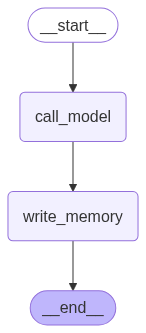

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
  """Load memory from the store and use it to personalize the chatbot's response."""

  # Get the user ID from the config
  user_id = config["configurable"]["user_id"]

  # Retrieve memory from the store
  namespace = ("memory", user_id)
  key = "user_memory"
  existing_memory = store.get(namespace, key)

  # Extract the actual memory content if it exists and add a prefix
  if existing_memory:
    # Value is a dictionary with a memory key
    existing_memory_content = existing_memory.value.get('memory')
  else:
    existing_memory_content = "No existing memory found."

  # Format the memory in the system prompt
  system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

  # Respond using memory as well as the chat history
  response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

  return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
  """Reflect on the chat history and save a memory to the store."""
  # Get the user ID from the config
  user_id = config["configurable"]["user_id"]

  # Retrieve existing memory from the store
  namespace = ("memory", user_id)
  existing_memory = store.get(namespace, "user_memory")

  # Extract the memory
  if existing_memory:
      existing_memory_content = existing_memory.value.get('memory')
  else:
      existing_memory_content = "No existing memory found."
  # Format the memory in the system prompt
  system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
  new_memory = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

  # Overwrite the existing memory in the store
  key = "user_memory"

  # Write value as a dictionary with a memory key
  store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model",call_model)
builder.add_node("write_memory",write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work together in practice.

In [13]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# user input
input_message = [HumanMessage(content="Hi, my name is Tharun")]

# Run the graph
for chunk in graph.stream({"messages":input_message}, config, stream_mode="values"):
  chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi, my name is Tharun
================================== Ai Message ==================================

Hello Tharun! It's nice to meet you. I'll remember your name.


In [14]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's great, Tharun! San Francisco has some beautiful (and challenging!) biking routes. I'll remember that you enjoy biking around the city.


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [15]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Tharun
================================== Ai Message ==================================

Hello Tharun! It's nice to meet you. I'll remember your name.
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's great, Tharun! San Francisco has some beautiful (and challenging!) biking routes. I'll remember that you enjoy biking around the city.


Recall that we compiled the graph with our the store:

```python
across_thread_memory = InMemoryStore()
```

And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [16]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '\n\nCURRENT USER INFORMATION:\n* Name: Tharun\n* Enjoys biking around San Francisco'},
 'created_at': '2025-09-01T12:20:51.403378+00:00',
 'updated_at': '2025-09-01T12:20:51.403380+00:00'}

Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [17]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Tharun! Since you enjoy biking around San Francisco, I'd definitely recommend checking out the Golden Gate Bridge bike path for iconic views, or the Presidio Promenade for a mix of nature and cityscapes. Both offer fantastic experiences!


In [18]:
# User input
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

That's a perfect post-biking treat!

If you're biking near the **Presidio Promenade**, you're in luck. **Arsicault Bakery** is a must-visit and often considered one of the best bakeries in the city, especially for croissants. It's a bit of a detour from the immediate promenade, but well worth it.

If you're closer to the **Golden Gate Bridge** (specifically the San Francisco side), you might find a few cafes with croissants, but for a dedicated bakery experience, Arsicault is still a strong contender if you're willing to head a bit south from the bridge. Another option, though a bit further into the Marina/Cow Hollow area, is **B. Patisserie**, which also has incredible pastries, including croissants.

Enjoy your croissant, Tharun!
